In [1]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.optimizers import Adamax
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Define paths
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'

In [3]:
def create_dataframe(dir):
    image_paths, labels = [], []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir, label)):
            image_paths.append(os.path.join(dir, label, imagename))
            labels.append(label)
    return image_paths, labels

In [4]:
# Load train and test data
train = pd.DataFrame()
train['image'], train['label'] = create_dataframe(TRAIN_DIR)
test = pd.DataFrame()
test['image'], test['label'] = create_dataframe(TEST_DIR)

In [5]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features).reshape(len(features), 48, 48, 1)
    return features

In [6]:
# Feature extraction
x_train = extract_features(train['image']) / 255.0
x_test = extract_features(test['image']) / 255.0

  0%|          | 0/28821 [00:00<?, ?it/s]

C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


  0%|          | 0/7066 [00:00<?, ?it/s]

In [7]:
# Label Encoding
y_train = to_categorical(pd.factorize(train['label'])[0], num_classes=7)
y_test = to_categorical(pd.factorize(test['label'])[0], num_classes=7)

In [8]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

In [9]:
# Model Definition
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(48,48,1), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile the Model
model.compile(optimizer=Adamax(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [12]:
# Train the Model
model_training = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    validation_data=(x_test, y_test),
                    epochs=100,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100


C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 301s 632ms/step - accuracy: 0.2099 - loss: 4.6403 - val_accuracy: 0.2593 - val_loss: 2.8248 - learning_rate: 0.0020
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 193s 427ms/step - accuracy: 0.2467 - loss: 2.6289 - val_accuracy: 0.3247 - val_loss: 2.1061 - learning_rate: 0.0020
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 187s 413ms/step - accuracy: 0.3086 - loss: 2.0791 - val_accuracy: 0.3740 - val_loss: 1.8848 - learning_rate: 0.0020
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 165s 365ms/step - accuracy: 0.3515 - loss: 1.8846 - val_accuracy: 0.4319 - val_loss: 1.7799 - learning_rate: 0.0020
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 164s 363ms/step - accuracy: 0.3868 - loss: 1.8042 - val_accuracy: 0.4519 - val_loss: 1.7248 - learning_rate: 0.0020
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 168s 371ms/step - accuracy: 0.4097 - loss: 1.7793 - val_accuracy: 0.4708 - val_loss: 1.6538 - learning_rate: 0.0020
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 196s 434ms/step - accuracy: 0

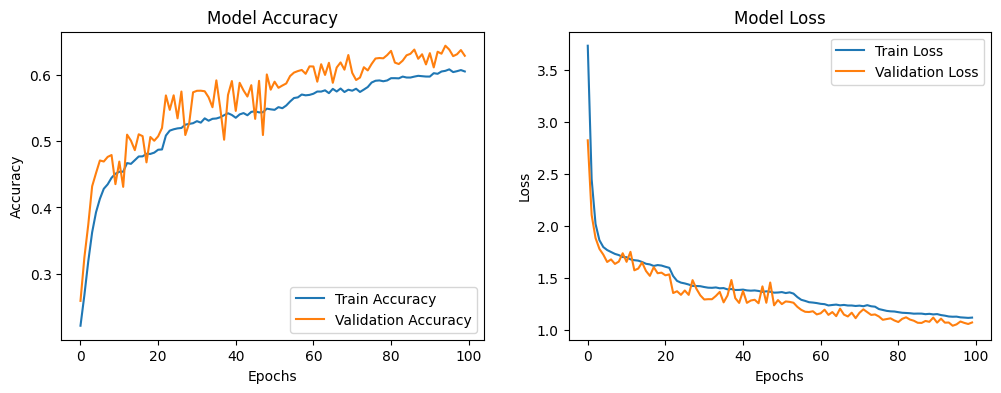

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_training.history['accuracy'], label='Train Accuracy')
plt.plot(model_training.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(model_training.history['loss'], label='Train Loss')
plt.plot(model_training.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [14]:
model.save("emotiondetector_full.h5")

In [15]:
from keras.models import load_model
model = load_model("emotiondetector_full.h5")

In [16]:
from keras_preprocessing.image import img_to_array

In [17]:
label = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [18]:
def preprocess_image(image):
    img = load_img(image, color_mode="grayscale", target_size=(48, 48))
    img = img_to_array(img) / 255.0  # Converts to NumPy array and normalizes
    img = np.expand_dims(img, axis=0)  # Adding batch dimension
    return img

In [19]:
image = 'images/train/sad/42.jpg'
print("Original image is of: Sad")

img = preprocess_image(image)  # Using the new function
pred = model.predict(img)
pred_label = label[np.argmax(pred)]  # Ensure correct indexing

print("Model prediction is:", pred_label)

Original image is of: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Model prediction is: sad


Original image is of: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Model prediction is: sad


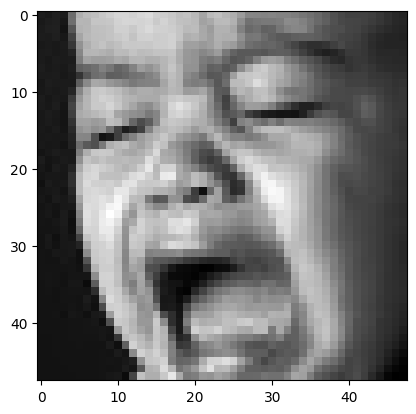

In [28]:
image = 'images/train/sad/1566.jpg'
print("Original image is of: Sad")

img = preprocess_image(image)  # Using the new function
pred = model.predict(img)
pred_label = label[np.argmax(pred)]  # Ensure correct indexing

print("Model prediction is:", pred_label)
plt.imshow(img.reshape(48,48),cmap='grey')